In \[ \]:

    # In this notebook, I tried to detect hand keypoints where there were two hands in the input images.
    # I also predicted the bounding boxes for each hands.

**Install the dependies**

In \[1\]:

    !pip install tensorflow==1.14

    Collecting tensorflow==1.14
      Downloading tensorflow-1.14.0-cp37-cp37m-manylinux1_x86_64.whl (109.3 MB)
         |████████████████████████████████| 109.3 MB 47 kB/s s eta 0:00:01
    Requirement already satisfied: keras-preprocessing>=1.0.5 in /opt/conda/lib/python3.7/site-packages (from tensorflow==1.14) (1.1.2)
    Requirement already satisfied: grpcio>=1.8.6 in /opt/conda/lib/python3.7/site-packages (from tensorflow==1.14) (1.30.0)
    Requirement already satisfied: protobuf>=3.6.1 in /opt/conda/lib/python3.7/site-packages (from tensorflow==1.14) (3.12.2)
    Collecting tensorboard<1.15.0,>=1.14.0
      Downloading tensorboard-1.14.0-py3-none-any.whl (3.1 MB)
         |████████████████████████████████| 3.1 MB 53.5 MB/s eta 0:00:01
    Requirement already satisfied: wheel>=0.26 in /opt/conda/lib/python3.7/site-packages (from tensorflow==1.14) (0.34.2)
    Collecting astor>=0.6.0
      Downloading astor-0.8.1-py2.py3-none-any.whl (27 kB)
    Collecting keras-applications>=1.0.6
      Downloading Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
         |████████████████████████████████| 50 kB 5.0 MB/s  eta 0:00:01
    Requirement already satisfied: absl-py>=0.7.0 in /opt/conda/lib/python3.7/site-packages (from tensorflow==1.14) (0.9.0)
    Requirement already satisfied: numpy<2.0,>=1.14.5 in /opt/conda/lib/python3.7/site-packages (from tensorflow==1.14) (1.18.5)
    Requirement already satisfied: six>=1.10.0 in /opt/conda/lib/python3.7/site-packages (from tensorflow==1.14) (1.14.0)
    Collecting tensorflow-estimator<1.15.0rc0,>=1.14.0rc0
      Downloading tensorflow_estimator-1.14.0-py2.py3-none-any.whl (488 kB)
         |████████████████████████████████| 488 kB 51.9 MB/s eta 0:00:01
    Requirement already satisfied: gast>=0.2.0 in /opt/conda/lib/python3.7/site-packages (from tensorflow==1.14) (0.3.3)
    Requirement already satisfied: termcolor>=1.1.0 in /opt/conda/lib/python3.7/site-packages (from tensorflow==1.14) (1.1.0)
    Requirement already satisfied: wrapt>=1.11.1 in /opt/conda/lib/python3.7/site-packages (from tensorflow==1.14) (1.11.2)
    Requirement already satisfied: google-pasta>=0.1.6 in /opt/conda/lib/python3.7/site-packages (from tensorflow==1.14) (0.2.0)
    Requirement already satisfied: setuptools in /opt/conda/lib/python3.7/site-packages (from protobuf>=3.6.1->tensorflow==1.14) (46.1.3.post20200325)
    Requirement already satisfied: werkzeug>=0.11.15 in /opt/conda/lib/python3.7/site-packages (from tensorboard<1.15.0,>=1.14.0->tensorflow==1.14) (1.0.1)
    Requirement already satisfied: markdown>=2.6.8 in /opt/conda/lib/python3.7/site-packages (from tensorboard<1.15.0,>=1.14.0->tensorflow==1.14) (3.2.1)
    Requirement already satisfied: h5py in /opt/conda/lib/python3.7/site-packages (from keras-applications>=1.0.6->tensorflow==1.14) (2.10.0)
    Installing collected packages: tensorboard, astor, keras-applications, tensorflow-estimator, tensorflow
      Attempting uninstall: tensorboard
        Found existing installation: tensorboard 2.2.2
        Uninstalling tensorboard-2.2.2:
          Successfully uninstalled tensorboard-2.2.2
      Attempting uninstall: tensorflow-estimator
        Found existing installation: tensorflow-estimator 2.2.0
        Uninstalling tensorflow-estimator-2.2.0:
          Successfully uninstalled tensorflow-estimator-2.2.0
      Attempting uninstall: tensorflow
        Found existing installation: tensorflow 2.2.0
        Uninstalling tensorflow-2.2.0:
          Successfully uninstalled tensorflow-2.2.0
    Successfully installed astor-0.8.1 keras-applications-1.0.8 tensorboard-1.14.0 tensorflow-1.14.0 tensorflow-estimator-1.14.0
    WARNING: You are using pip version 20.1.1; however, version 20.2.1 is available.
    You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.

Import the libraries

In \[3\]:

    import tensorflow as tf
    import time
    from PIL import Image
    print(tf.__version__)
    import sys
    sys.path.append('../input/handpose/Hand Pose')
    root='../input/handpose/Hand Pose/'
    import numpy as np
    import sys
    import os

    import detection_rectangles
    from utils import draw_util
    from matplotlib import pyplot as plt
    import cv2

    1.14.0

**Function for placing a bounding box on a white background**

In \[4\]:

    def Reformat_Image(img,im_width, im_height):

        from PIL import Image
        from skimage.transform import resize

        width = img.shape[1]
        height = img.shape[0]
        image = Image.fromarray(img)
        image_size = image.size
        print(image_size)
        bigsidew = im_width
        bigsideh = im_height

        background = Image.new('RGB', (bigsidew, bigsideh), (255, 255, 255))
        offset = (int(round(((bigsidew - width) / 2), 0)), int(round(((bigsideh - height) / 2),0)))
        print("offset: ",offset)
        background.paste(image, offset)
        print(background.size)
        result= np.array(background)
        #result= resize(result, (224,224,3))
        plt.imshow(result)
        plt.savefig('result.png')
        print(result.shape)
        print("Image has been resized !")
        return result

**Function for plotting multiple images**

In \[5\]:

    def plot_multiple_img(img_matrix_list, title_list, ncols, main_title="Hand Pose"):
        fig, myaxes = plt.subplots(figsize=(20, 15), nrows=2, ncols=ncols, squeeze=True)
        fig.suptitle(main_title, fontsize = 30)
        #fig.subplots_adjust(wspace=0.3)
        #fig.subplots_adjust(hspace=0.3)
        for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
            myaxes[i // ncols][i % ncols].imshow(img)
            myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
        plt.show()

**Load An Image as Input**

In \[81\]:

    #image_np= Image.open(root+'body.jpg')
    file='../input/hand-pose-estimation/Hand Data/Multiple hands/t2.jpg'
    image_np= cv2.imread(file)
    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    im_width = image_np.shape[1]
    im_height = image_np.shape[0]
    print(im_width,im_height)

    2527 3774

**Load the detection graph**

In \[82\]:

    detection_graph, sess = detection_rectangles.load_inference_graph()

    > ====== loading HAND frozen graph into memory
    >  ====== Hand Inference graph loaded.

Get bounding boxes and scores for the input image

In \[83\]:

    relative_boxes, scores, classes = detection_rectangles.detect_objects(image_np, detection_graph, sess)

Get the bounding boxes.

In \[84\]:

    box_relative2absolute = lambda box: (box[1] * im_width, box[3] * im_width, box[0] * im_height, box[2] * im_height)
    hand_boxes = []

    ###Take the best 2 boxes for 2 hands
    hand_boxes.append(box_relative2absolute(relative_boxes[0]))
    hand_boxes.append(box_relative2absolute(relative_boxes[1]))
    print(hand_boxes)

    [(982.936873793602, 1800.5169614553452, 829.3047899901867, 2044.9559615850449), (965.4793799817562, 1608.8729056119919, 2023.3431894779205, 3193.747715950012)]

In \[15\]:

    image=draw_util.draw_box_on_image(hand_boxes,  image_np)
    plt.imshow(image)

Out\[15\]:

    <matplotlib.image.AxesImage at 0x7f6f0a9dad90>

<img src="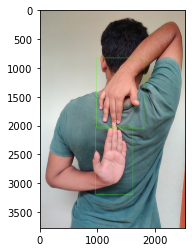%0A" class="jp-needs-light-background" />

Load Keypoint Detector

In \[85\]:

    protoFile = root+"hand/pose_deploy.prototxt"
    weightsFile = root+"hand/pose_iter_102000.caffemodel"
    nPoints = 22
    POSE_PAIRS = [ [0,1],[1,2],[2,3],[3,4],[0,5],[5,6],[6,7],[7,8],[0,9],[9,10],[10,11],[11,12],[0,13],[13,14],[14,15],[15,16],[0,17],[17,18],[18,19],[19,20] ]
    net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

Detect Keypoints from bounding boxes

In \[86\]:

    count=1
    img_matrix_list=[]
    for box in hand_boxes:
      xmin= int(box[0])
      xmax= int(box[1])
      ymin= int(box[2])
      ymax= int(box[3])
      print(ymin,ymax,xmin,xmax)
      result= image_np[ymin:ymax,xmin:xmax,:]
      im_width = 2*result.shape[1]
      im_height = 2*result.shape[0]
      frame= Reformat_Image(result,im_width,im_height)

      frameCopy = np.copy(frame)
      print(frame.shape)
      frameWidth = frame.shape[1]
      frameHeight = frame.shape[0]
      print(frameWidth,frameHeight)
      aspect_ratio = frameWidth/frameHeight

      threshold = 0.5

      t = time.time()
      # input image dimensions for the network
      inHeight = 368
      inWidth = int(((aspect_ratio*inHeight)*8)//8)
      inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)
      print(inpBlob.shape)
      net.setInput(inpBlob)

      output = net.forward()
      #print(output)
      print("time taken by network : {:.3f}".format(time.time() - t))

        # Empty list to store the detected keypoints
      points = []

      for i in range(nPoints):
        # confidence map of corresponding body's part.
        probMap = output[0, i, :, :]
        probMap = cv2.resize(probMap, (frameWidth, frameHeight))

        # Find global maxima of the probMap.
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
        #print(probMap)
        #print(point)
        #print()
            
        if prob > threshold :
            point= list(point)
            addx= point[0]+xmin
            addy= point[1]+ymin
            point= tuple(point)
            cv2.circle(frameCopy, (int(point[0]), int(point[1])), 2, (27, 74, 29), thickness=1, lineType=cv2.FILLED)
            cv2.putText(frameCopy, "{}".format(i), (int(point[0]), int(point[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.25, (0, 0, 255), 2, lineType=cv2.LINE_AA)


            #cv2.circle(image_np, (int(addx), int(addy)), 8, (27, 74, 29), thickness=1, lineType=cv2.FILLED)
            # Add the point to the list if the probability is greater than the threshold
            points.append((int(point[0]), int(point[1])))
            print(int(point[0]),int(point[1]))
        else :
            points.append(None)
      
      img_matrix_list.append(frameCopy)

      # Draw Skeleton
      for pair in POSE_PAIRS:
        partA = pair[0]
        partB = pair[1]

        if points[partA] and points[partB]:
            cv2.line(frame, points[partA], points[partB], (0, 255, 255), 8)
            cv2.circle(frame, points[partA], 2, (0, 0, 255), thickness=2, lineType=cv2.FILLED)
            cv2.circle(frame, points[partB], 2, (0, 0, 255), thickness=2, lineType=cv2.FILLED)

      img_matrix_list.append(frame)
      nymin= frame.shape[0] // 4
      nymax= nymin + frame.shape[0] // 2
      nxmin= frame.shape[1] // 4
      nxmax= nxmin + frame.shape[1] // 2
      #r_imgs.append(frame[nymin:nymax,nxmin:nxmax,:])

      count=count+2

    829 2044 982 1800
    (818, 1215)
    offset:  (409, 608)
    (1636, 2430)
    (2430, 1636, 3)
    Image has been resized !
    (2430, 1636, 3)
    1636 2430
    (1, 3, 368, 247)
    time taken by network : 2.059
    976 1030
    1029 1188
    1029 1294
    1081 1452
    817 1294
    765 1505
    765 1611
    765 1717
    712 1293
    659 1505
    607 1241
    606 1400
    554 1558
    553 1716
    554 1136
    501 1294
    501 1399
    500 1505
    2023 3193 965 1608
    (643, 1170)
    offset:  (322, 585)
    (1286, 2340)
    (2340, 1286, 3)
    Image has been resized !
    (2340, 1286, 3)
    1286 2340
    (1, 3, 368, 202)
    time taken by network : 1.504

<img src="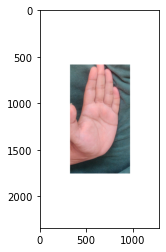%0A" class="jp-needs-light-background" />

**Plot the results**

In \[87\]:

    titles_list = ["Hand 1","Hand1","Hand 2","Hand 2"]
    plot_multiple_img(img_matrix_list, titles_list, ncols = 2)

<img src="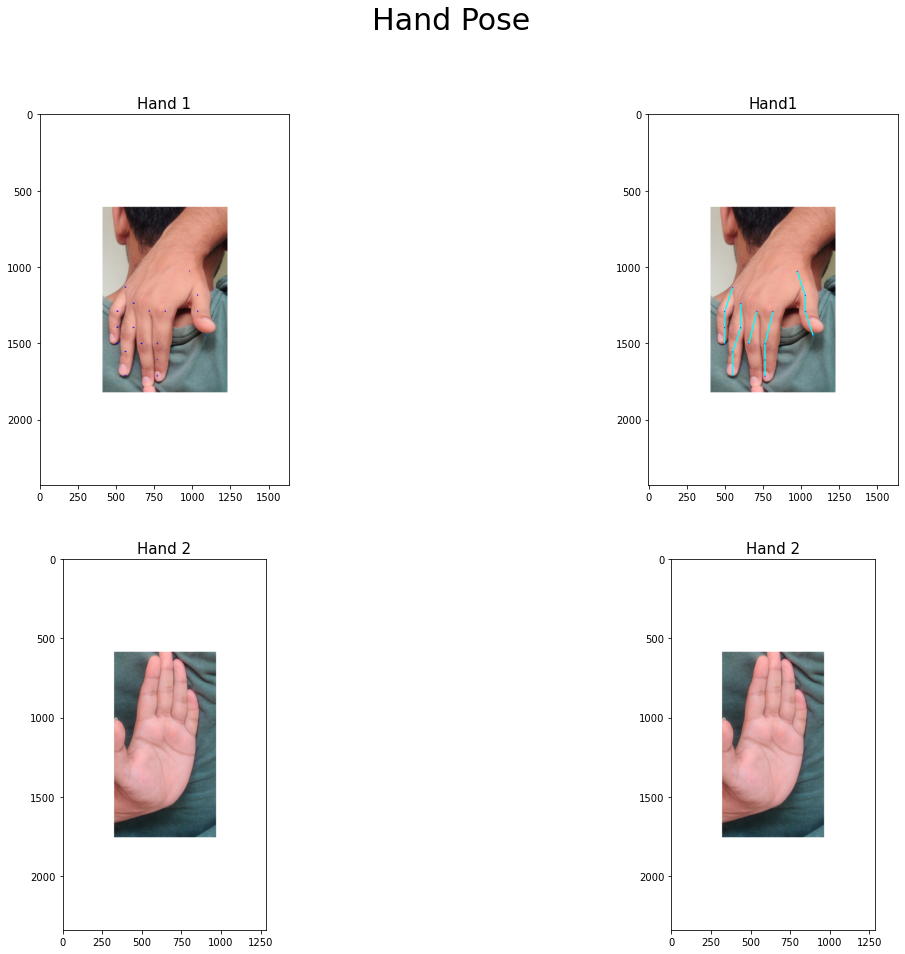%0A" class="jp-needs-light-background" />

# Check to see if two boxes overlap or not<a href="#Check-to-see-if-two-boxes-overlap-or-not" class="anchor-link">¶</a>

**Function to check overlapping of two bounding boxes**

In \[88\]:

    #https://stackoverflow.com/questions/20925818/algorithm-to-check-if-two-boxes-overlap
    # Overlap check for 1D rectangle
    def isOverlapping1D(box1,box2):
        #print(box1,box2)
        xmax1= box1[1]
        xmin1= box1[0]
        xmax2= box2[1]
        xmin2= box2[0]
        return xmax1 >= xmin2 and xmax2 >= xmin1

    def isOverlapping2D(box1,box2):
        return isOverlapping1D(box1['x'], box2['x']) and isOverlapping1D(box1['y'], box2['y'])

**Check overlap**

In \[89\]:

    box1 = {'x':(hand_boxes[0][0],hand_boxes[0][1]),'y':(hand_boxes[0][2],hand_boxes[0][3])}
    box2 = {'x':(hand_boxes[1][0],hand_boxes[1][1]),'y':(hand_boxes[1][2],hand_boxes[1][3])}

    if isOverlapping2D(box1,box2):
        print("The bounding boxes are overlapping.")
    else:
        print("The bounding boxes are not ovelapping")

    The bounding boxes are overlapping.

# Adjust bounding box for better detection<a href="#Adjust-bounding-box-for-better-detection" class="anchor-link">¶</a>

In \[90\]:

    def adjust_bbox(hand_boxes):
        updated_hand_boxes=[]
        for box in hand_boxes:
            xmin= int(box[0])
            xmax= int(box[1])
            ymin= int(box[2])
            ymax= int(box[3])
            
            xmin= xmin - (xmax-xmin)/2
            xmax= xmax + (xmax-xmin)/2
            
            updated_box= [xmin,xmax,ymin,ymax]
            updated_hand_boxes.append(updated_box)
        
        return updated_hand_boxes

In \[91\]:

    updated_hand_boxes= adjust_bbox(hand_boxes)
    print(updated_hand_boxes)
    print(hand_boxes)

    [[573.0, 2413.5, 829, 2044], [643.5, 2090.25, 2023, 3193]]
    [(982.936873793602, 1800.5169614553452, 829.3047899901867, 2044.9559615850449), (965.4793799817562, 1608.8729056119919, 2023.3431894779205, 3193.747715950012)]

In \[92\]:

    count=1
    img_matrix_list=[]
    r_imgs=[]
    for box in updated_hand_boxes:
      xmin= int(box[0])
      xmax= int(box[1])
      ymin= int(box[2])
      ymax= int(box[3])
      print(ymin,ymax,xmin,xmax)
      result= image_np[ymin:ymax,xmin:xmax,:]
      #im_width = 2*result.shape[1]
      #im_height = 2*result.shape[0]
      #frame= Reformat_Image(result,im_width,im_height)
      frame= result
      frameCopy = np.copy(frame)
      print(frame.shape)
      frameWidth = frame.shape[1]
      frameHeight = frame.shape[0]
      print(frameWidth,frameHeight)
      aspect_ratio = frameWidth/frameHeight

      threshold = 0.5

      t = time.time()
      # input image dimensions for the network
      inHeight = 368
      inWidth = int(((aspect_ratio*inHeight)*8)//8)
      inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)
      print(inpBlob.shape)
      net.setInput(inpBlob)

      output = net.forward()
      #print(output)
      print("time taken by network : {:.3f}".format(time.time() - t))

        # Empty list to store the detected keypoints
      points = []

      for i in range(nPoints):
        # confidence map of corresponding body's part.
        probMap = output[0, i, :, :]
        probMap = cv2.resize(probMap, (frameWidth, frameHeight))

        # Find global maxima of the probMap.
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
        #print(probMap)
        #print(point)
        #print()
            
        if prob > threshold :
            point= list(point)
            addx= point[0]+xmin
            addy= point[1]+ymin
            point= tuple(point)
            cv2.circle(frameCopy, (int(point[0]), int(point[1])), 2, (27, 74, 29), thickness=1, lineType=cv2.FILLED)
            cv2.putText(frameCopy, "{}".format(i), (int(point[0]), int(point[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.25, (0, 0, 255), 2, lineType=cv2.LINE_AA)


            #cv2.circle(image_np, (int(addx), int(addy)), 8, (27, 74, 29), thickness=1, lineType=cv2.FILLED)
            # Add the point to the list if the probability is greater than the threshold
            points.append((int(point[0]), int(point[1])))
            print(int(point[0]),int(point[1]))
        else :
            points.append(None)
      
      img_matrix_list.append(frameCopy)

      # Draw Skeleton
      for pair in POSE_PAIRS:
        partA = pair[0]
        partB = pair[1]

        if points[partA] and points[partB]:
            cv2.line(frame, points[partA], points[partB], (0, 255, 255), 8)
            cv2.circle(frame, points[partA], 2, (0, 0, 255), thickness=2, lineType=cv2.FILLED)
            cv2.circle(frame, points[partB], 2, (0, 0, 255), thickness=2, lineType=cv2.FILLED)

      img_matrix_list.append(frame)
      #nymin= frame.shape[0] // 4
      #nymax= nymin + frame.shape[0] // 2
      #nxmin= frame.shape[1] // 4
      #nxmax= nxmin + frame.shape[1] // 2
      r_imgs.append(frame)

      count=count+2

    829 2044 573 2413
    (1215, 1840, 3)
    1840 1215
    (1, 3, 368, 557)
    time taken by network : 3.894
    1038 594
    1038 726
    1117 805
    801 673
    775 885
    775 1017
    775 1122
    696 673
    670 884
    696 1043
    617 621
    591 832
    565 990
    538 1096
    539 593
    486 700
    486 805
    486 910
    2023 3193 643 2090
    (1170, 1447, 3)
    1447 1170
    (1, 3, 368, 455)
    time taken by network : 3.187
    368 725
    317 597
    343 470
    545 495
    545 267
    570 140
    596 38
    647 266
    647 114
    698 521
    723 394
    748 190
    723 63
    774 571
    799 445
    824 343
    799 242

In \[93\]:

    titles_list = ["Hand 1-Keypoint","Hand1-Skeleton","Hand 2-keypoint","Hand 2-skeleton"]
    plot_multiple_img(img_matrix_list, titles_list, ncols = 2)

<img src="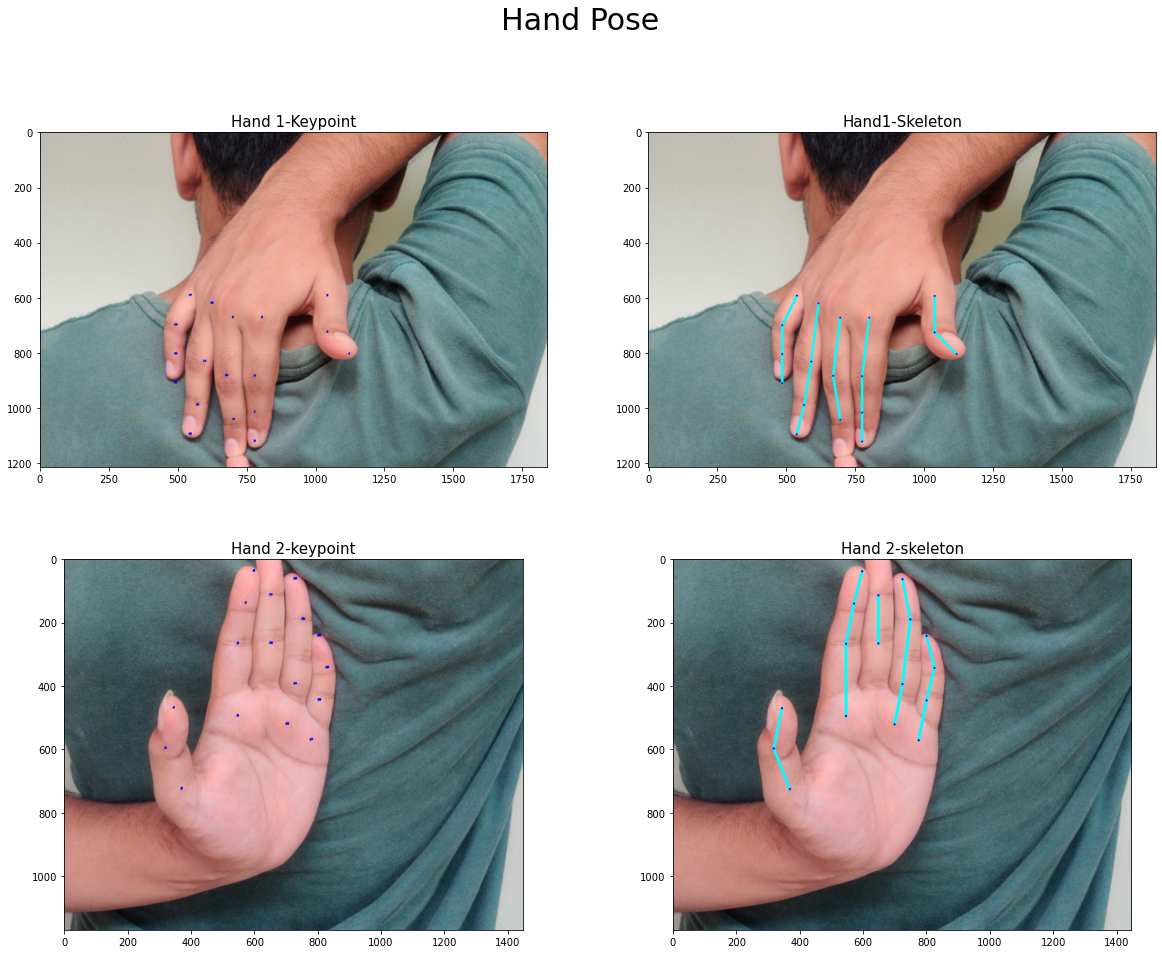%0A" class="jp-needs-light-background" />

**Place the detected bounding boxes on the original image**

In \[94\]:

    background = Image.fromarray(image_np)
    for i in range(len(r_imgs)):
      os2= (int(updated_hand_boxes[i][0]),int(updated_hand_boxes[i][2]))
      print(os2)
      background.paste(Image.fromarray(r_imgs[i]), os2)

    result= np.array(background)
    plt.imshow(result)

    (573, 829)
    (643, 2023)

Out\[94\]:

    <matplotlib.image.AxesImage at 0x7f6f08d949d0>

<img src="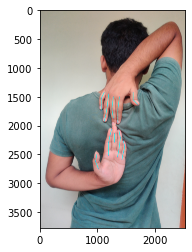%0A" class="jp-needs-light-background" />

**Save the output**

In \[95\]:

    cv2.imwrite('Final_result.jpg',result)

Out\[95\]:

    True

In \[ \]:

     

In \[ \]:

     

In \[ \]: